<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [70]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn import metrics
import warnings
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [71]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-04-28 08:17:27--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-04-28 08:17:27 (12.4 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [72]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [73]:
df.shape

(346, 10)

### Convert to date time object 

In [74]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [75]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [76]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



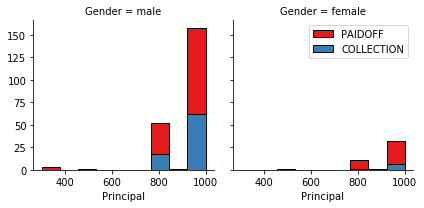

In [77]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

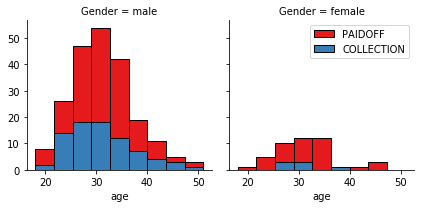

In [78]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

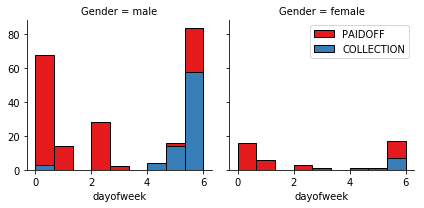

In [79]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [80]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [81]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [82]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [83]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [84]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [85]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [86]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [87]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [88]:
warnings.filterwarnings('ignore')
X= preprocessing.StandardScaler().fit(X).transform(X)


## Split data into training ant testing sets

The function "train_test_split" in "sklearn.model_selection" is used to split the classification set in training and testing sets. 

In [89]:
from sklearn.model_selection import train_test_split

#Set random seed
np.random.seed(1)

#Get the training and test sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (242, 8) (242,)
Test set: (104, 8) (104,)


## Predictor subsets

In order to get the best classification model, all possible subsets of predictors will be tested, with a minimum of two predictors in each subset. All predictor combinations are generated below. A function to access column index in numpy arrays is also defined.

In [90]:
#Combination of different predictors
colscomb = []
cols = list(Feature.columns)
for L in range(1, len(cols)+1):
    for subset in itertools.combinations(cols, L):
        colscomb.append(list(subset))

print ('The number of different column combinations is:', len(colscomb))
col_np = np.array(colscomb)

#Define the function to get column index based on the column(predictor) name in numpy arrays
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]


The number of different column combinations is: 255


# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

### Best k parameter

In order to find the best value for k, a loop is generated testing the accuracy scores for a range of k. A plot shows the distribution of the values. Highest accuracy points are highlighted in blue.

Best k values are: [ 9 21 28]


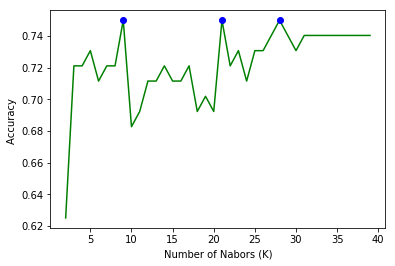

In [91]:
from sklearn.neighbors import KNeighborsClassifier

#Make a loop to test the best K, minimum K=3 and maximum k=30
Kmax=40
acc_vec = np.zeros((Kmax-2))
k_vec = np.arange(2,Kmax,1,dtype=int)
len(acc_vec)
n=0
for k in range(2,Kmax):
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    acc_vec[n] = metrics.accuracy_score(y_test, yhat)
    n= n+1

best_acc = acc_vec.max()
best_acc#0.75
i=np.where(acc_vec == best_acc)
print('Best k values are:', k_vec[i])

plt.plot(range(2,Kmax),acc_vec,'g')
plt.plot(k_vec[i],acc_vec[i],'bo')
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.show()

k_def=28

There are three values giving the best accuracy, 9, 21 and 28. However, I choose to use 28 as in the distribution, accuracy values are high and constant after this point.

### Best predictor variables

In order to build the best model, some predictor variables may be better than others. To select the best set of predictor variables, a loop is used below. There are two predictor sets that give the maximum accuracy, none of them contains the sex variable. I selected the first one to build the final model.

In [92]:
acc_vec = np.zeros(len(col_np))
for s in range(8,len(col_np)):
    ci=column_index(Feature,colscomb[s] )
    X_sub=X_train[:,ci]
    neigh = KNeighborsClassifier(n_neighbors = k_def).fit(X_sub,y_train)
    
    X_test_sub=X_test[:,ci]
    yhat=neigh.predict(X_test_sub)
    acc_vec[s] = metrics.accuracy_score(y_test, yhat)


best_acc = acc_vec.max()
i=np.where(acc_vec == best_acc)
col_np[i]

neigh_col=col_np[i][0]

### Build the KNN model

Build the model with the parameters selected in previous sections.

In [93]:
warnings.filterwarnings('ignore')
X_def=Feature[neigh_col]
X_def= preprocessing.StandardScaler().fit(X_def).transform(X_def)
neigh = KNeighborsClassifier(n_neighbors = k_def).fit(X_def,y)
print('For K:',k_def,'Train set Accuracy: ', metrics.accuracy_score(y, neigh.predict(X_def)))

For K: 28 Train set Accuracy:  0.7572254335260116


# Decision Tree

### Best max_depth parameter

A range of max_depth values will be tested to get the one giving the best accuracy. Best values are highlighted in blue in the plot. max_depth=6 was set as optimum value.

The Max Depth that give best accuracy are: [5 6]


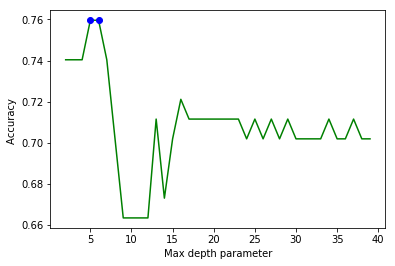

In [94]:
from sklearn.tree import DecisionTreeClassifier

maxD=40
acc_vec = np.zeros(maxD-2)
d_vec = np.arange(2,maxD,1,dtype=int)
len(acc_vec)
n=0
for d in range(2,maxD):
    modTree = DecisionTreeClassifier(criterion="gini",max_depth = d)
    modTree.fit(X_train,y_train)
    yhat=modTree.predict(X_test)
    acc_vec[n] = metrics.accuracy_score(y_test, yhat)
    n= n+1

best_acc = acc_vec.max()
best_acc#0.7596153846153846
i=np.where(acc_vec == best_acc)

print("The Max Depth that give best accuracy are:",d_vec[i])

plt.plot(d_vec,acc_vec,'g')
plt.plot(d_vec[i],acc_vec[i],'bo')
plt.ylabel('Accuracy ')
plt.xlabel('Max depth parameter')
plt.show()

d_def=6

### Best predictor variables

As it has been done in the KNN model. All the subsets of predictor variables are tested in a loop. In this case, best accuracy can be reached with variables: 'terms', 'Gender', 'weekend', 'High School or Below' and 'college' 

In [95]:
acc_vec = np.zeros(len(col_np))
for s in range(8,len(col_np)):
    #print(s)
    ci=column_index(Feature,colscomb[s])
    X_sub=X_train[:,ci]
    modTree = DecisionTreeClassifier(criterion="gini", max_depth = d_def)
    modTree.fit(X_sub,y_train)
    
    X_test_sub=X_test[:,ci]
    yhat=modTree.predict(X_test_sub)
    acc_vec[s] = metrics.accuracy_score(y_test, yhat)


best_acc = acc_vec.max()
best_acc#0.7692307692307693
i=np.where(acc_vec == best_acc)
col_np[i]

modTree_col=col_np[i][0]
modTree_col

['terms', 'Gender', 'weekend', 'High School or Below', 'college']

### Build the Decision Tree model

With the optimum max_depth parameter and the subset of columns the final model is built:

In [96]:
X_def=Feature[modTree_col]
X_def= preprocessing.StandardScaler().fit(X_def).transform(X_def)
modTree = DecisionTreeClassifier(criterion="gini", max_depth = d_def)
modTree.fit(X_def,y)
yhat=modTree.predict(X_def)
print('For depth:',d_def,'Train set Accuracy:', metrics.accuracy_score(y, yhat))

For depth: 6 Train set Accuracy: 0.7687861271676301


# Support Vector Machine

### Best kernel parameter

Test all possible kernel parameters and choose the one that gives the best accuracy. As it is shown in the plot poly and rbf are optimum kernels. The default kernel "rbf" will be used.

For kernel: linear Test set Accuracy:  0.7403846153846154
For kernel: poly Test set Accuracy:  0.75
For kernel: rbf Test set Accuracy:  0.75
For kernel: sigmoid Test set Accuracy:  0.7115384615384616


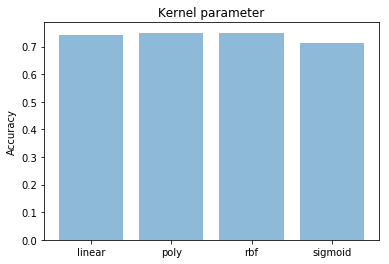

Kernel parameters: ['poly' 'rbf'] give the best accuracy: 0.75


In [97]:
from sklearn import svm

kern=np.array(['linear', 'poly', 'rbf', 'sigmoid'])
acc_vec = np.zeros(len(kern))
n=0
for d in range(0,len(kern)):
    clf = svm.SVC(kernel=kern[d])
    clf.fit(X_train, y_train) 
    yhat = clf.predict(X_test)
    acc_vec[n] = metrics.accuracy_score(y_test, yhat)
    print('For kernel:',kern[d],'Test set Accuracy: ', acc_vec[n])
    n= n+1

#Show accuracy results
y_pos = np.arange(len(kern))
plt.bar(y_pos, acc_vec, align='center', alpha=0.5)
plt.xticks(y_pos, kern)
plt.ylabel('Accuracy')
plt.title('Kernel parameter')
plt.show()

#dir(acc_vec)
best_acc = acc_vec.max()
best_acc#0.75
i=np.where(acc_vec == best_acc)
kern[i]

print('Kernel parameters:',kern[i],'give the best accuracy:',best_acc)

ker_def='rbf'

### Best inverse regularization strength parameter

The optimum value for inverse regularization strength parameter is set to 1, as the default. 

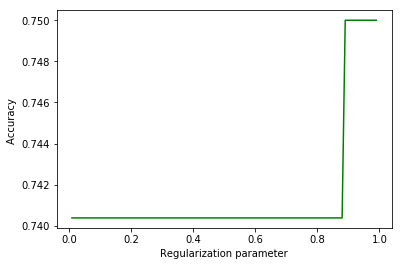

Default C=1 gives accuracy: 0.75


In [98]:
maxC=1
c_vec = np.arange(0.01,maxC,0.01,dtype=float)
acc_vec = np.zeros(len(c_vec))
len(acc_vec)
n=0
for c in range(0,len(c_vec)):
    clf = svm.SVC(C=c_vec[c],kernel=ker_def)
    clf.fit(X_train, y_train) 
    yhat = clf.predict(X_test)
    acc_vec[n] = metrics.accuracy_score(y_test, yhat)
    n= n+1

#Show results in a plot
plt.plot(c_vec,acc_vec,'g')
plt.ylabel('Accuracy ')
plt.xlabel('Regularization parameter')
plt.show()

best_acc = acc_vec.max()
best_acc#0.7596153846153846
i=np.where(acc_vec == best_acc)
c_vec[i]

print('Default C=1 gives accuracy:',best_acc)

### Best predictor variables

In the case of SVM, all predictors can be used and give the best accuracy.

In [99]:
acc_vec = np.zeros(len(col_np))
for s in range(8,len(col_np)):
    ci=column_index(Feature,colscomb[s])
    X_sub=X_train[:,ci]
    clf = svm.SVC(C=1,kernel=ker_def)
    clf.fit(X_sub, y_train) 
    
    X_test_sub=X_test[:,ci]
    yhat = clf.predict(X_test_sub)
    acc_vec[s] = metrics.accuracy_score(y_test, yhat)


best_acc = acc_vec.max()
best_acc#0.75
i=np.where(acc_vec == best_acc)

print('There are',len(col_np[i]),' subsets of predictors giving the best accuracy, these are:',col_np[i])


There are 27  subsets of predictors giving the best accuracy, these are: [list(['Principal', 'age', 'weekend', 'college'])
 list(['Principal', 'Gender', 'weekend', 'Bechalor'])
 list(['terms', 'Gender', 'weekend', 'Bechalor'])
 list(['Principal', 'terms', 'age', 'weekend', 'Bechalor'])
 list(['Principal', 'terms', 'Gender', 'weekend', 'Bechalor'])
 list(['Principal', 'age', 'Gender', 'weekend', 'Bechalor'])
 list(['Principal', 'age', 'weekend', 'Bechalor', 'High School or Below'])
 list(['Principal', 'age', 'weekend', 'Bechalor', 'college'])
 list(['Principal', 'Gender', 'weekend', 'Bechalor', 'High School or Below'])
 list(['Principal', 'Gender', 'weekend', 'Bechalor', 'college'])
 list(['terms', 'age', 'Gender', 'weekend', 'High School or Below'])
 list(['terms', 'Gender', 'weekend', 'Bechalor', 'High School or Below'])
 list(['terms', 'Gender', 'weekend', 'Bechalor', 'college'])
 list(['Principal', 'terms', 'age', 'Gender', 'weekend', 'Bechalor'])
 list(['Principal', 'terms', 'age',

### Build the SVM model

In [100]:
clf = svm.SVC(C=1,kernel=ker_def)
clf.fit(X, y) 
yhat=clf.predict(X)
print('For kernel',ker_def,', training set Accuracy is:', metrics.accuracy_score(y, yhat))

For kernel rbf , training set Accuracy is: 0.7601156069364162


# Logistic Regression

### Best solver parameter

In the case of logistic regression, accuracy and logLoss will be used to find the best parameters. Different from accuracy measure low Log Loss means a low uncertainty/entropy in the model. The sover with better accuracy and lolLoss scores was "saga".

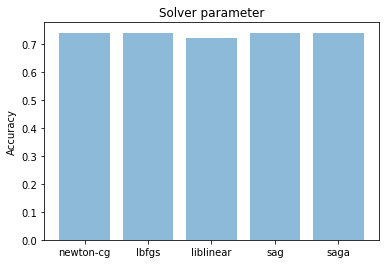

Best accuracy 0.7403846153846154 is with solver parameters: ['newton-cg' 'lbfgs' 'sag' 'saga']


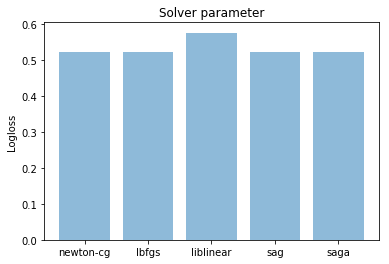

Best logLoss 0.52258817863813 is with solver parameters: ['sag']
Using accuracy and logLoss scores, the best solver is: sag


In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

solv=np.array(['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
acc_vec = np.zeros(len(solv))
loss_vec= np.zeros(len(solv))

for d in range(0,len(solv)):
    LR = LogisticRegression(C=0.01, solver=solv[d]).fit(X_train,y_train)
    yhat = LR.predict(X_test)
    acc_vec[d] = metrics.accuracy_score(y_test, yhat)
    yhat_prob = LR.predict_proba(X_test)
    loss_vec[d] = log_loss(y_test, yhat_prob)

#Show accuracy results
y_pos = np.arange(len(solv))
plt.bar(y_pos, acc_vec, align='center', alpha=0.5)
plt.xticks(y_pos, solv)
plt.ylabel('Accuracy')
plt.title('Solver parameter')
plt.show()

best_acc = acc_vec.max()
best_acc#0.7403846153846154
a=np.where(acc_vec == best_acc)
solv[a]
print('Best accuracy',best_acc ,'is obtained with solver parameters:',solv[a])

#Show loss results
y_pos = np.arange(len(solv))
plt.bar(y_pos, loss_vec, align='center', alpha=0.5)
plt.xticks(y_pos, solv)
plt.ylabel('Logloss')
plt.title('Solver parameter')
plt.show()

best_loss = loss_vec.min()
best_loss#0.5225834560738991
l=np.where(loss_vec == best_loss)
solv[l]
print('Best logLoss',best_loss ,'is obtained with solver parameters:',solv[l])

#Best method is the intersection of both
solv_def=np.intersect1d(solv[a], solv[l])[0]
print('Using accuracy and logLoss scores, the best solver is:',solv_def)

### Best regularization strength parameter

Different regularization strength parameters are tested.

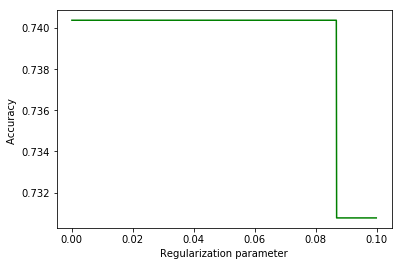

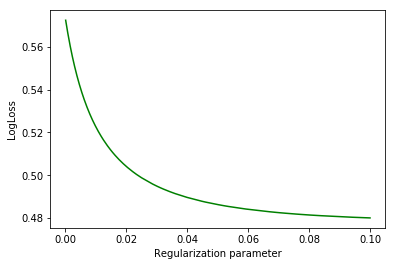

Based on LogLoss and accuracy parameters, the consensus value for C would be around 0.08


In [102]:
c_vec = np.arange(0.0001, 0.1, 0.0001,dtype=float)
acc_vec = np.zeros(len(c_vec))
loss_vec= np.zeros(len(c_vec))
for c in range(0,len(c_vec)):
    LR = LogisticRegression(C=c_vec[c], solver=solv_def).fit(X_train,y_train)
    yhat = LR.predict(X_test)
    acc_vec[c] = metrics.accuracy_score(y_test, yhat)
    yhat_prob = LR.predict_proba(X_test)
    loss_vec[c] = log_loss(y_test, yhat_prob)

   
plt.plot(c_vec,acc_vec,'g')
plt.ylabel('Accuracy ')
plt.xlabel('Regularization parameter')
plt.show()

plt.plot(c_vec,loss_vec,'g')
plt.ylabel('LogLoss')
plt.xlabel('Regularization parameter')
plt.show()

print('Based on LogLoss and accuracy parameters, the consensus value for C would be around 0.08')
c_def=0.08

### Best predictor variables

The best predictors, based on the logLoss and accuracy measures are used to build the final model.

In [103]:

acc_vec = np.zeros(len(col_np))
loss_vec= np.ones(len(col_np))
for s in range(8,len(col_np)):
    #print(s)
    ci=column_index(Feature,colscomb[s])
    X_sub=X_train[:,ci]
    LR = LogisticRegression(C=c_def, solver=solv_def).fit(X_sub,y_train)
    X_test_sub=X_test[:,ci]
    yhat = LR.predict(X_test_sub)
    yhat_prob = LR.predict_proba(X_test_sub)
    
    acc_vec[s] = metrics.accuracy_score(y_test, yhat)
    loss_vec[s] = log_loss(y_test, yhat_prob)

best_acc = acc_vec.max()
best_acc#0.7403846153846154
print('Best accuracy found is:',best_acc)
a=np.where(acc_vec == best_acc)

best_loss = loss_vec.min()
best_loss#0.46328159211448106
print('Best LogLoss found is:',best_loss)
l=np.where(loss_vec == best_loss)

intrsct = np.intersect1d(col_np[a], col_np[l])
print('Columns with best accuracy and logLoss are:',intrsct[0])

LR_col=intrsct[0]


Best accuracy found is: 0.7403846153846154
Best LogLoss found is: 0.4632801649609096
Columns with best accuracy and logLoss are: ['terms', 'Gender', 'weekend', 'Bechalor', 'High School or Below']


### Build the Logistic regression model

In [104]:
X_def=Feature[LR_col]
X_def= preprocessing.StandardScaler().fit(X_def).transform(X_def)
LR = LogisticRegression(C=c_def, solver=solv_def).fit(X_def,y)

yhat = LR.predict(X_def)
yhat_prob = LR.predict_proba(X_def)

print('Train set Accuracy:', metrics.accuracy_score(y, yhat))
print('Train set LogLoss:', log_loss(y, yhat_prob))

Train set Accuracy: 0.7514450867052023
Train set LogLoss: 0.4444414656541971


# Model Evaluation using Test set

In [105]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [106]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-04-28 08:20:23--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-04-28 08:20:23 (311 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [114]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Pre-processing of Test set

In [115]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
#Convert the variable education
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
print('The size of the feature test set is:', Feature_test.shape)
#Select labels
y_Test = test_df['loan_status'].values
print('The size of the labels in the test set is:', y_Test.shape)

The size of the feature test set is: (54, 8)
The size of the labels in the test set is: (54,)


## KNN evaluation

In [109]:
#Predict with the test dataset
X_knn_test = Feature_test[neigh_col]
X_knn_test = preprocessing.StandardScaler().fit(X_knn_test).transform(X_knn_test.astype(float))
yhat = neigh.predict(X_knn_test)
#Evaluate the model
print("Jaccard similarity score is: ", jaccard_similarity_score(y_Test, yhat))
print("f1 score is: ",f1_score(y_Test, yhat, average='weighted'))

Jaccard similarity score is:  0.8333333333333334
f1 score is:  0.8122605363984674


## Decision Tree evaluation

In [110]:
#Predict with the test dataset
X_mt_test = Feature_test[modTree_col]
X_mt_test = preprocessing.StandardScaler().fit(X_mt_test).transform(X_mt_test.astype(float))
yhat=modTree.predict(X_mt_test)
#Evaluate the model
print("Jaccard similarity score is: ", jaccard_similarity_score(y_Test, yhat))
print("f1 score is: ",f1_score(y_Test, yhat, average='weighted'))

Jaccard similarity score is:  0.7592592592592593
f1 score is:  0.7401723974614001


## Suport Vector Machine evaluation

In [111]:
#Predict with the test dataset
X_svm_test=Feature_test
X_svm_test = preprocessing.StandardScaler().fit(X_svm_test).transform(X_svm_test.astype(float))
yhat=clf.predict(X_svm_test)
#Evaluate the model
print("Jaccard similarity score is: ", jaccard_similarity_score(y_Test, yhat))
print("f1 score is: ",f1_score(y_Test, yhat, average='weighted'))

Jaccard similarity score is:  0.7222222222222222
f1 score is:  0.6212664277180406


## Logistic regression evaluation

In [112]:
#Predict with the test dataset
X_lr_test = Feature_test[LR_col]
X_lr_test = preprocessing.StandardScaler().fit(X_lr_test).transform(X_lr_test.astype(float))
yhat = LR.predict(X_lr_test)
yhat_prob = LR.predict_proba(X_lr_test)
#Evaluate the model
print("Jaccard similarity score is: ", jaccard_similarity_score(y_Test, yhat))
print("f1 score is: ",f1_score(y_Test, yhat, average='weighted'))
print('LogLoss score is:', log_loss(y_Test, yhat_prob))

Jaccard similarity score is:  0.7407407407407407
f1 score is:  0.6304176516942475
LogLoss score is: 0.4804971403452501


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.8333 | 0.8122  | NA      |
| Decision Tree      | 0.7592       | 0.7401        | NA      |
| SVM                | 0.7222       | 0.6212        | NA      |
| LogisticRegression | 0.7407       | 0.6304        | 0.4805       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>